# Main Training Pipeline

In [1]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch
import os

# Setting CUDA visible devices to restrict model training to specific GPUs
os.environ['CUDA_VISIBLE_DEVICES'] = "1,2,3"

# Loading the tokenizer for the model from the specified pretrained model
tokenizer = AutoTokenizer.from_pretrained("deepseek-ai/deepseek-coder-7b-instruct", device_map='auto')

# Loading the pretrained model for causal language modeling
model = AutoModelForCausalLM.from_pretrained(
    "deepseek-ai/deepseek-coder-7b-instruct",  # Model identifier or directory path
    device_map='auto'  # Map tensors to specified devices (GPU or CPU)
)


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [2]:
import torch  # Importing PyTorch library

# Function to generate text based on input texts using a model
def generate(input_texts, model):
    # Encode input texts using the tokenizer and move tensors to GPU ('cuda')
    encoded_input = tokenizer.batch_encode_plus(
        input_texts,
        padding=True,
        truncation=True,
        return_tensors="pt"
    ).to('cuda')

    # Generate text based on the encoded input using the model
    output = model.generate(
        **encoded_input,  # Unpack encoded input as keyword arguments
        max_new_tokens=4096,  # Maximum number of tokens to generate
        pad_token_id=tokenizer.eos_token_id,  # ID of the padding token
        do_sample=True,  # Whether to sample from the distribution instead of using argmax
        top_k=50,  # Number of top tokens to sample from
        top_p=0.95,  # Cumulative probability for top-k sampling
        use_cache=True  # Whether to use cached values in generation
    )
    
    # Decode the generated output into text and remove special tokens
    generated_texts = [
        tokenizer.decode(
            output[i][len(encoded_input['input_ids'][i]):],  # Exclude input text from generated output
            skip_special_tokens=True  # Skip special tokens (like <eos>)
        ).strip()  # Remove leading/trailing whitespace
        for i in range(len(input_texts))  # Iterate over each input text
    ]
    
    return generated_texts  # Return the generated texts


In [3]:
import numpy as np
import os

# Function to sample implementations from files in a directory
def sample_implementations(n_implemenations=50, dir='generated_code'):
    # Get a list of all filenames in the specified directory (excluding .ipynb_checkpoints)
    all_filenames = [filename for filename in os.listdir(dir) if filename != '.ipynb_checkpoints']
    # Randomly select n_implemenations filenames from the list
    filenames = np.random.choice(all_filenames, size=n_implemenations)
    samples = []
    # Read the content of each selected file and append it to the samples list
    for filename in filenames:
        with open(f'{dir}/{filename}') as f:
            samples.append(f.read())
    return samples


In [4]:
# samples = sample_implementations()

In [5]:
from tqdm import tqdm

# Load the description of Maintainability Index from file
with open('mi_desc.txt') as f:
    mi_desc = f.read()

# Function to compose a prompt for rewriting code
def compose_prompt_to_rewrite(code):
    # Construct the instruction using the description of Maintainability Index and the provided code
    instruction = f"Here is a description of Maintainability Index:\n\n{mi_desc}\n\n\
    Here is a Python code whose maintainability index you need to improve:\n\n{code}\n\n\
    Please, rewrite the Python code given above so that its maintainability index is increased."

    # Apply a chat template to the instruction using tokenizer
    prompt = tokenizer.apply_chat_template(
        [{ 'role': 'user', 'content': instruction}],
        add_generation_prompt=True,
        tokenize=False
    )

    return prompt

# Function to rewrite a batch of code
def rewrite_code_batch(code_batch, model, batch_size=5):
    # Compose prompts for each code in the batch
    prompts = [compose_prompt_to_rewrite(code) for code in code_batch]
    output = []
    # Generate responses for the prompts in batches
    for i in tqdm(range(len(prompts)//batch_size)):
        output += generate(prompts[i*batch_size:(i+1)*batch_size], model) 
    return output

# Function to rewrite a batch of code and extract the rewritten code
def rewrite_and_extract_code_batch(code_batch, model, batch_size=5):
    # Rewrite the code batch using the model
    rewritten_code_raw = rewrite_code_batch(code_batch, model, batch_size)
    rewritten_code = []
    skipped_samples_idx = [] 
    # Extract the rewritten code from the generated responses
    for i, text in enumerate(rewritten_code_raw):
        extracted_code = extract_code(text)
        # Check if code extraction failed
        if len(extracted_code) == 0:
            print(f'Failed to extract code from the answer {i}')
            skipped_samples_idx.append(i)
            rewritten_code.append("")
        else:
            rewritten_code.append(extracted_code[0])
    return rewritten_code, rewritten_code_raw, skipped_samples_idx


In [6]:
import re

def extract_code(code):
    # Define a regular expression pattern to match Python code blocks within triple backticks
    pattern = r'```python\n(.*?)\n```'
    # Use re.findall() to find all matches of the pattern in the input code string
    matches = re.findall(pattern, code, re.DOTALL)
    # Return the matched code blocks as a list
    return matches

In [7]:
import requests
import json
import os


def compute_mi(code):
    # Constructing a dictionary containing the code
    data = {"code": code}
    # Converting the dictionary to JSON format
    json_data = json.dumps(data)
    
    # Making a POST request to compute the maintainability index (MI)
    new_response = requests.post(
        # URL for the endpoint to compute MI (uncomment the appropriate line based on environment)
        "http://localhost:8002/compute_mi",  # URL for local endpoint
        data=json_data,  # Sending the JSON data in the request body
        headers={'Content-Type': 'application/json'}  # Setting the request headers
    )
    
    # Parsing the JSON response and returning it as a Python dictionary
    return new_response.json()


In [8]:
from trl import DPOTrainer
from transformers import TrainingArguments
from datasets import Dataset
from peft import (
    LoraConfig,
    get_peft_model,
    get_peft_model_state_dict,
    prepare_model_for_kbit_training,
    set_peft_model_state_dict,
    PeftModel
)

def compose_train_dataset(prompts, best_variants, worst_variants, original_variants):
    # Identify indices of samples where the best variant is not better than the original
    idx_to_skip = [
        idx for idx in range(len(prompts))
        if original_variants[idx]['mi'] > best_variants[idx]['mi']
    ]
    # Print a message if any samples are excluded from the training dataset
    if len(idx_to_skip) != 0:
        print(f'Samples {idx_to_skip} are excluded from training dataset because their best variants are not actually better than original ones.')
    # Create a Dataset object containing prompts, chosen (best variants), and rejected (worst variants)
    return Dataset.from_dict({
        'prompt': [prompts[idx] for idx in range(len(prompts)) if not idx in idx_to_skip],
        'chosen': [best_variants[idx]['text_raw'] for idx in range(len(prompts)) if not idx in idx_to_skip],
        'rejected': [worst_variants[idx]['text_raw'] for idx in range(len(prompts)) if not idx in idx_to_skip]
    })

def train(model, train_dataset, output_dir='./dpo_output_dir/'):
    # Define configuration for the Lora model
    peft_config = LoraConfig(
        r=32,
        lora_alpha=64,
        lora_dropout=0.05,
        target_modules=[  # Modules to apply PEFT on
            "q_proj",
            "k_proj",
            "v_proj",
            "o_proj",
            "gate_proj",
            "up_proj",
            "down_proj",
            "lm_head"
         ], 
        bias="none",
        task_type="CAUSAL_LM",
    )

    # Prepare the base model for knowledge distillation
    base_model = prepare_model_for_kbit_training(model)
    # Create a PEFT model based on the base model and PEFT configuration
    peft_model = get_peft_model(base_model, peft_config)
    
    # Define training arguments for the model
    training_args = TrainingArguments(
        per_device_train_batch_size=1,
        gradient_accumulation_steps=1,
        warmup_steps=25,
        num_train_epochs=1,
        do_eval=False,
        learning_rate=3e-4,
        fp16=True,
        logging_steps=50,
        optim="adamw_torch",
        save_strategy="epoch",
        output_dir=output_dir,
        load_best_model_at_end=False,
        report_to="none",
        remove_unused_columns=False,
    )

    # Create a DPOTrainer object for training
    dpo_trainer = DPOTrainer(
         model,
         ref_model= None,
         args=training_args,
         peft_config=peft_config,
         beta=0.1,
         train_dataset=train_dataset,
         tokenizer=tokenizer,  # Assuming `tokenizer` is defined elsewhere
         max_prompt_length=4096,
         max_length=2*4096,
    )

    # Train the model using DPOTrainer
    dpo_trainer.train()

    # Merge the trained model and unload the PEFT part
    return dpo_trainer.model.merge_and_unload()


Setting ds_accelerator to cuda (auto detect)


In [9]:
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
from pathlib import Path
from pprint import pprint

def dpo_iteration(
    iteration_name,
    model,
    n_samples=10,
    batch_size=2,
    n_tries_to_rewrite=2,
    original_code_dir='generated_code',
    mi_hist_dir='dpo_mi/hist',
    struct_dir='dpo_mi/struct',
):

    # Printing iteration name
    print(f'=== Iteration {iteration_name} ===')

    # Define a structure to store all the necessary data
    struct = [
        {
            'code_variants': [
                {
                    'text': None,
                    'text_raw': None,
                    'is_original': False,
                    'mi': None
                }
                for i in range(n_tries_to_rewrite + 1)
            ],
            'original_variant': None,
            'best_variant': None,
            'worst_variant': None,
            # 'skip': False
        }
        for i in range(n_samples)
    ]
    
    # 1. Sample several implementations from the dataset
    # Printing progress message
    print('--> Sampling code')
    # Sampling original code from the dataset
    original_code = sample_implementations(
        n_implemenations=n_samples, dir=original_code_dir
    )

    # Store original code in the structure
    for i, code in enumerate(original_code):
        struct[i]['code_variants'][0]['text'] = code
        struct[i]['code_variants'][0]['is_original'] = True
        struct[i]['original_variant'] = struct[i]['code_variants'][0]
    
    # 2. Ask the model to rewrite the implementations to have higher MI
    # Printing progress message
    print('--> Asking to improve MI')
    for attempt_idx in range(n_tries_to_rewrite):
        # Printing attempt number
        print(f'Attempt {attempt_idx}')
        # Rewrite the original code using the model
        rewritten_code, rewritten_code_raw, skipped_samples_idx = rewrite_and_extract_code_batch(
            original_code, model,batch_size
        )
        # Store rewritten code in the structure
        for i in range(len(rewritten_code)):
            struct[i]['code_variants'][1+attempt_idx]['text'] = rewritten_code[i]
            struct[i]['code_variants'][1+attempt_idx]['text_raw'] = rewritten_code_raw[i]

    # 3. Calculate MIs for the implementations with higher MI
    # Printing progress message
    print('--> Calculating MI for code variants')
    for i in range(len(struct)):
        # Calculate maintainability index (MI) for each code variant
        mi_json = compute_mi([variant['text'] for variant in struct[i]['code_variants']])
        mi_values = [item['maintainability_index'] for item in mi_json]
        # Store MI values in the structure
        for j in range(len(struct[i]['code_variants'])):
            struct[i]['code_variants'][j]['mi'] = mi_values[j]

    # 4. Select best and worst variants in terms of MI
    # Printing progress message
    print('--> Choosing best and worst variants')
    for i in range(len(struct)):
        # Find the index of the variant with the highest MI
        # It does not consider original variant
        best_variant_idx = np.argmax([
            variant['mi'] if variant['mi'] != None
            else -np.inf
            for variant in struct[i]['code_variants'][1:]  
        ])
        # Set best variant
        struct[i]['best_variant'] = struct[i]['code_variants'][1 + best_variant_idx]
        
        # Find the index of the variant with the lowest MI
        # It does not consider original variant
        worst_variant_idx = np.argmin([
            variant['mi'] if variant['mi'] != None
            else np.inf
            for variant in struct[i]['code_variants'][1:]  
        ])
        # Set worst variant
        struct[i]['worst_variant'] = struct[i]['code_variants'][1 + worst_variant_idx]

    # Save the histogram to a file
    # Creating a new figure
    plt.figure()
    # Plotting histogram of MI values
    plt.hist([item['worst_variant']['mi'] for item in struct], edgecolor='black')
    # Setting labels and titles
    plt.title('Distribution of Maintainability Index')  
    plt.xlabel('Maintainability Index')
    plt.ylabel('Frequency')
    plt.savefig(f'{mi_hist_dir}/{iteration_name}.png')
    # Displaying the plot
    plt.show()

    # 5. Train the model on the pairs.
    # Printing progress message
    print('--> Training model')
    prompts = [
        compose_prompt_to_rewrite(code)
        for i, code in enumerate(original_code)
        if not i in skipped_samples_idx 
    ]

    # Prepare necessary data for training
    best_variants = [item['best_variant'] for item in struct]
    worst_variants = [item['worst_variant'] for item in struct]
    original_variants = [item['original_variant'] for item in struct]
    # Compose a training dataset with prompts, code with high MI, and code with low MI
    train_dataset = compose_train_dataset(prompts, best_variants, worst_variants, original_variants)
    # Train for one epoch
    model = train(model, train_dataset)
    
    # 6. Finish Iteration
    # Printing progress message
    print('--> Iteration finished\n')
    # Saving structure to a JSON file
    with open(f'{struct_dir}/{iteration_name}.json', 'w') as f:
        json.dump(struct, f)
    return model


=== Iteration 0 ===
--> Sampling code
--> Asking to improve MI
Attempt 0


100%|██████████| 5/5 [05:17<00:00, 63.58s/it]


Failed to extract code from the answer 2
Failed to extract code from the answer 16
Failed to extract code from the answer 20
Failed to extract code from the answer 22
Failed to extract code from the answer 24
Failed to extract code from the answer 27
Failed to extract code from the answer 36
Failed to extract code from the answer 44
Attempt 1


100%|██████████| 5/5 [04:38<00:00, 55.71s/it]


Failed to extract code from the answer 2
Failed to extract code from the answer 3
Failed to extract code from the answer 5
Failed to extract code from the answer 13
Failed to extract code from the answer 18
Failed to extract code from the answer 19
Failed to extract code from the answer 24
Failed to extract code from the answer 28
Failed to extract code from the answer 46
--> Calculating MI for code variants
--> Choosing best and worst variants


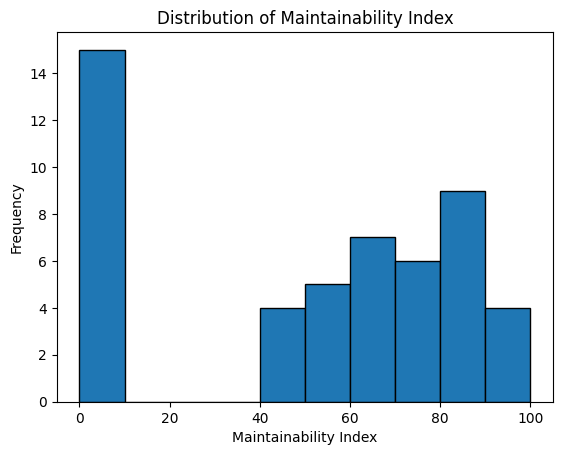

--> Training model
Samples [2, 3, 5, 12, 16, 18, 20, 21, 22, 24, 26, 28, 31, 34, 38, 39] are excluded from training dataset because         their best variants are not actually better than original ones.


Map:   0%|          | 0/25 [00:00<?, ? examples/s]

Could not estimate the number of tokens of the input, floating-point operations will not be computed


Step,Training Loss


--> Iteration finished

=== Iteration 1 ===
--> Sampling code
--> Asking to improve MI
Attempt 0


100%|██████████| 5/5 [06:02<00:00, 72.58s/it]


Failed to extract code from the answer 11
Attempt 1


100%|██████████| 5/5 [05:34<00:00, 66.91s/it]


--> Calculating MI for code variants
--> Choosing best and worst variants


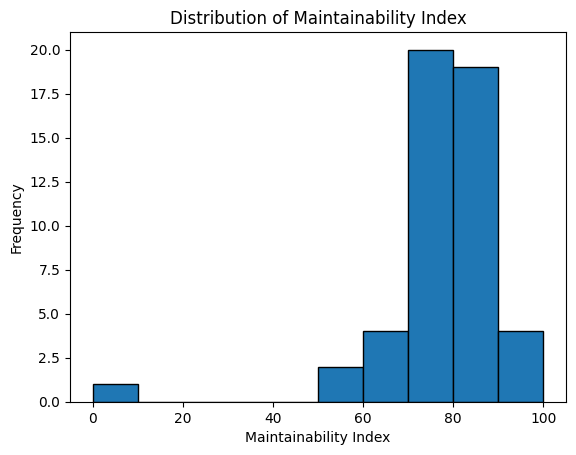

--> Training model
Samples [19, 20, 22, 26, 33] are excluded from training dataset because         their best variants are not actually better than original ones.


Map:   0%|          | 0/45 [00:00<?, ? examples/s]

Step,Training Loss


--> Iteration finished

=== Iteration 2 ===
--> Sampling code
--> Asking to improve MI
Attempt 0


100%|██████████| 5/5 [05:51<00:00, 70.33s/it]


Failed to extract code from the answer 13
Failed to extract code from the answer 16
Failed to extract code from the answer 21
Failed to extract code from the answer 27
Failed to extract code from the answer 28
Failed to extract code from the answer 30
Failed to extract code from the answer 37
Failed to extract code from the answer 38
Attempt 1


100%|██████████| 5/5 [05:32<00:00, 66.49s/it]


Failed to extract code from the answer 0
Failed to extract code from the answer 1
Failed to extract code from the answer 4
Failed to extract code from the answer 6
Failed to extract code from the answer 9
Failed to extract code from the answer 12
Failed to extract code from the answer 13
Failed to extract code from the answer 14
Failed to extract code from the answer 15
Failed to extract code from the answer 20
Failed to extract code from the answer 21
Failed to extract code from the answer 31
Failed to extract code from the answer 32
Failed to extract code from the answer 35
Failed to extract code from the answer 42
Failed to extract code from the answer 49
--> Calculating MI for code variants
--> Choosing best and worst variants


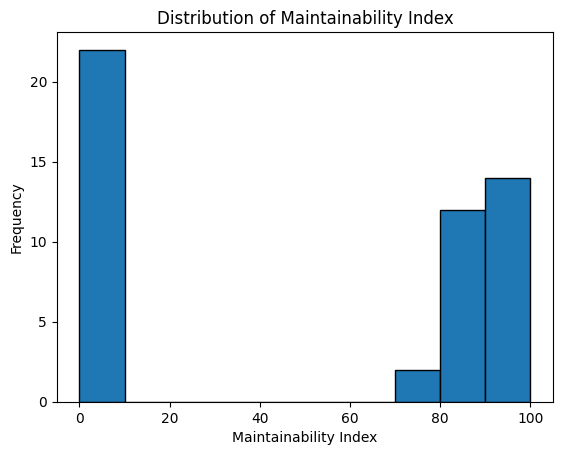

--> Training model
Samples [0, 13, 21, 22, 27] are excluded from training dataset because         their best variants are not actually better than original ones.


Map:   0%|          | 0/29 [00:00<?, ? examples/s]

Step,Training Loss


--> Iteration finished

=== Iteration 3 ===
--> Sampling code
--> Asking to improve MI
Attempt 0


100%|██████████| 5/5 [05:59<00:00, 72.00s/it]


Failed to extract code from the answer 24
Attempt 1


100%|██████████| 5/5 [06:28<00:00, 77.76s/it]


Failed to extract code from the answer 7
Failed to extract code from the answer 43
Failed to extract code from the answer 46
Failed to extract code from the answer 48
--> Calculating MI for code variants
--> Choosing best and worst variants


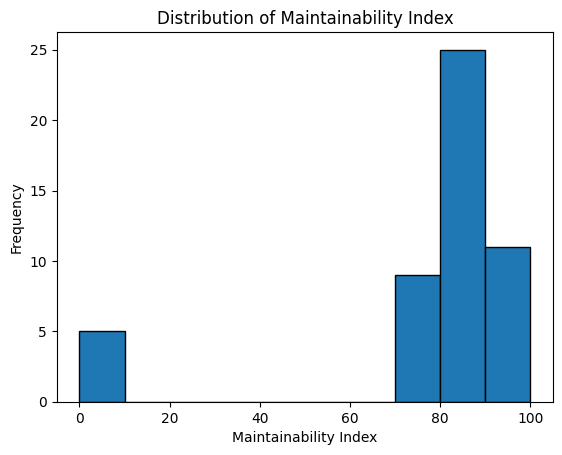

--> Training model
Samples [2, 19, 22, 33, 39] are excluded from training dataset because         their best variants are not actually better than original ones.


Map:   0%|          | 0/41 [00:00<?, ? examples/s]

Step,Training Loss


--> Iteration finished

=== Iteration 4 ===
--> Sampling code
--> Asking to improve MI
Attempt 0


 20%|██        | 1/5 [01:11<04:46, 71.50s/it]


RuntimeError: CUDA error: unspecified launch failure
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [10]:
for i in range(5):
    model = dpo_iteration(i, model, n_samples=50, batch_size=10, n_tries_to_rewrite=2)